# Kaggle Titanic Challenge

Most of this code will be from this site: https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html.
Thanks to him for providing me a tutorial on how to get started with this dataset.

## Exploring the Data

- Load the data and look into it
- Clean it
- Plot some charts to get some insight
- Form some hypothesis from the charts

### Import libraries 

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 100

from matplotlib import pyplot as plt

import numpy as np

import seaborn as sns

import pylab as plot
params = {
    'axes.labelsize': 'large',
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25,7]
}
plt.rcParams.update(params)

### Load in the training set

In [2]:
data = pd.read_csv('./train.csv')
print(data.shape)
data.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Describe the training set
Since the total number of rows is 891, then Age has 891-714 missing values. We solve this by filling all missing values with the median of the Age overall.
The median is more robust to outliers, so we don't overestimate or underestimate the distribution of Age.

In [3]:
data.Age = data.Age.fillna(data.Age.median())
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Making some charts

#### Chart of Survival based on Gender
This chart answers: __How many men and women died onboard the Titanic?__

Here's how the second line works:
First, we group _data_ by _Sex_, then get the sum of each column for each level of _Sex_. This returns an aggregated DataFrame, which we then select only certain columns from; in this case, we are inspecting _Survived_ and _Died_. Then, we plot the data in these two columns.

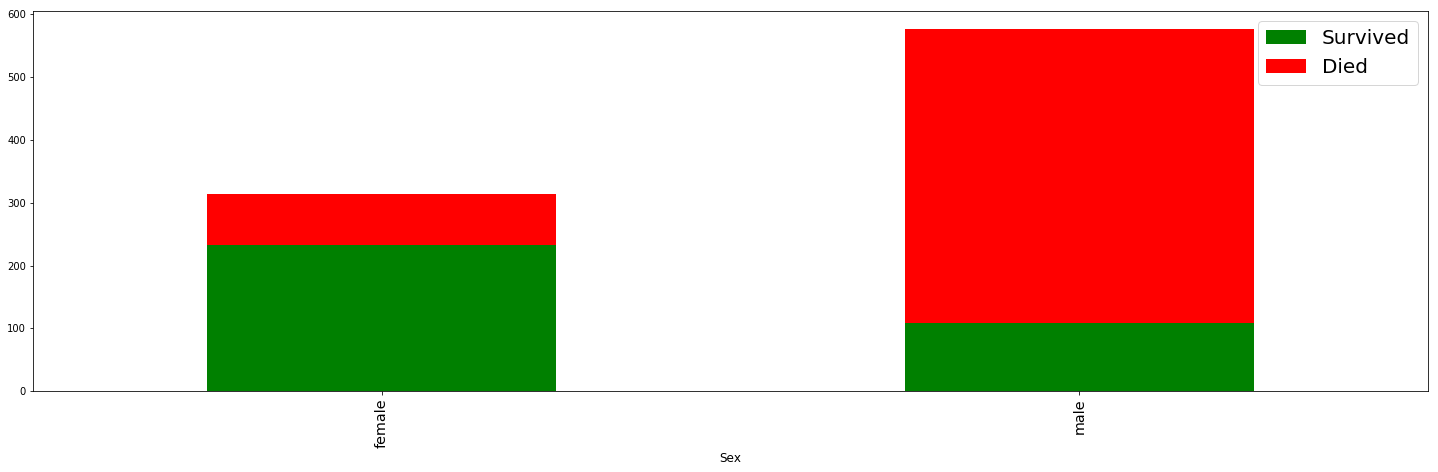

In [4]:
data['Died'] = 1 - data.Survived
data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25,7), stacked=True, color=['g','r'])

From the data above, men are more likely to die.

#### Chart of Survival on Age and Gender
This chart answers the question: __What is the age that most females survived? How about men?__

From the data, 

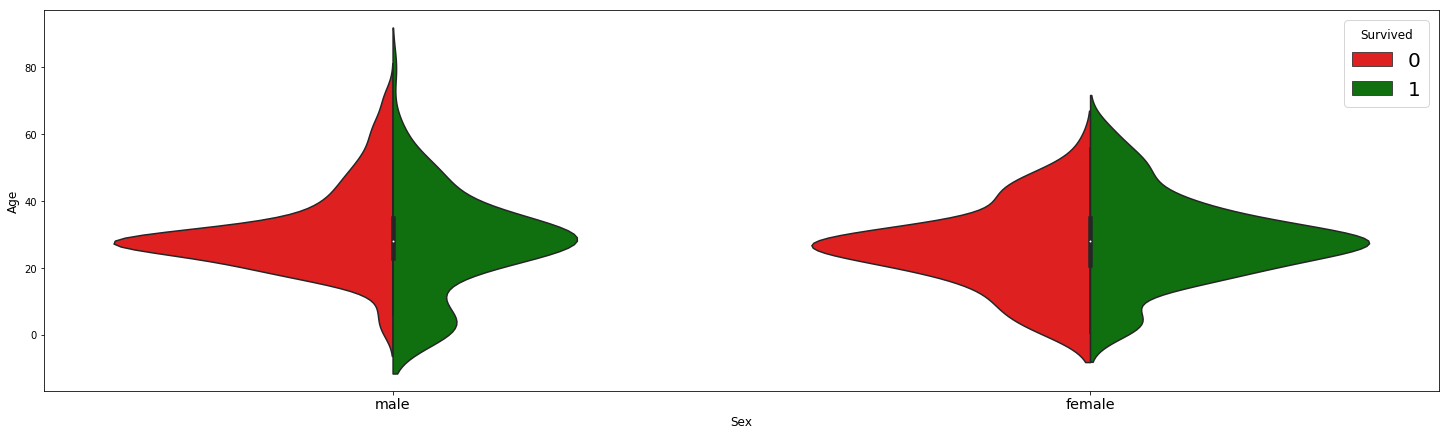

In [5]:
fig = plt.figure(figsize=(25,7))
sns.violinplot(x='Sex', y='Age', hue='Survived', data=data, split=True, palette={0: 'r', 1: 'g'})

Here, we see that passengers around 20-40 years old are more likely to die.. However, there were more female passengers who survived the Titanic being that age. Also, it seems like age did not have an effect on females surviving. Younger and older passengers were more likely to live, too. Of the men onboard, younger men tended to survive.

#### Chart of Survival on Fare
This answers the question: __How did a passenger's fare impact survival?__

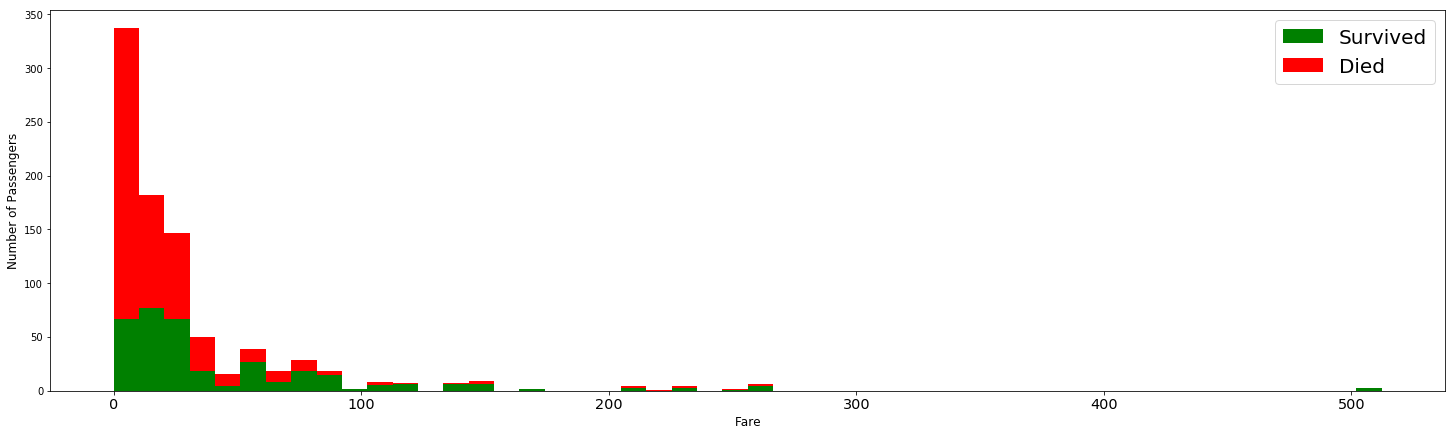

In [6]:
figure = plt.figure(figsize=(25,7))
plt.hist([ data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare'] ], 
        stacked=True, color=['g', 'r'], bins=50, label=['Survived', 'Died'])
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')
plt.legend()

Passengers with a cheaper ticket were more likely to die, while passengers with a more expensive ticket were rescued first.

#### Chart of Age, Fare, and Survival in a Scatterplot
Here, we can see how age and fare affect survival.

Text(0,0.5,'Fare')

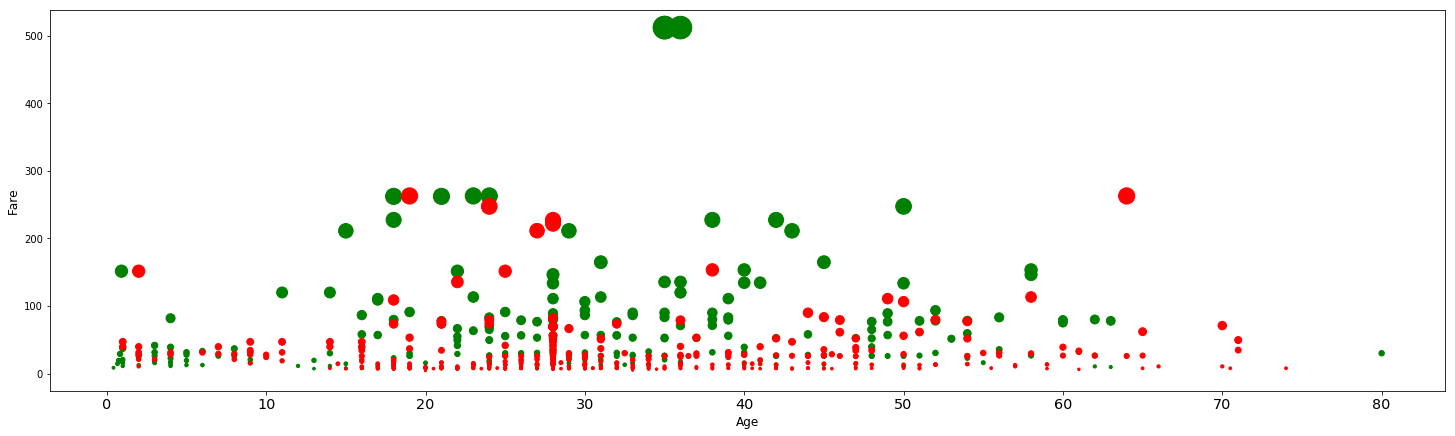

In [7]:
plt.figure(figsize=(25,7))
ax=plt.subplot()

ax.scatter(data[data['Survived'] == 1]['Age'], data[data['Survived'] == 1]['Fare'],
          c='green', s=data[data['Survived'] == 1]['Fare'])
ax.scatter(data[data['Survived'] == 0]['Age'], data[data['Survived'] == 0]['Fare'],
          c='red', s=data[data['Survived'] == 0]['Fare'])

ax.set_xlabel('Age')
ax.set_ylabel('Fare')

Here, we see that higher fares (larger green dots) meant a better chance at surviving. 

#### Chart of Passenger Class on Fare
This chart answers the question: __For each class, what is the mean Fare associated with them?__

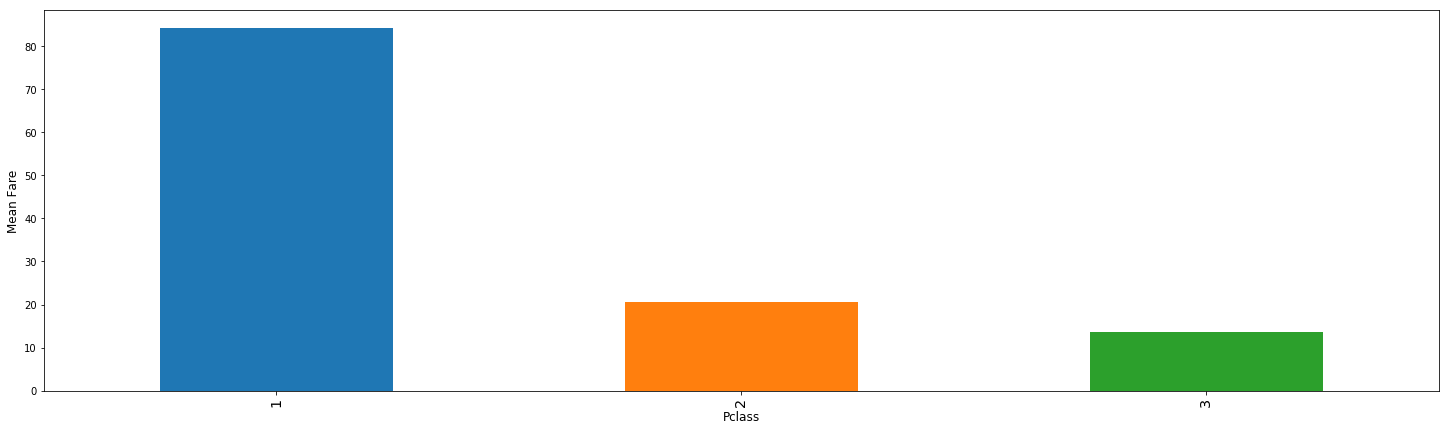

In [8]:
ax = plt.subplot()
ax.set_ylabel('Mean Fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(25,7), ax=ax)

Above, we see that passengers riding first class had, on average, a higher fare.

#### Chart of Embarkation and Fare on Survival
This chart answers: __How does the place of Embarkation affect Survival? What is the Fare like at these places?__

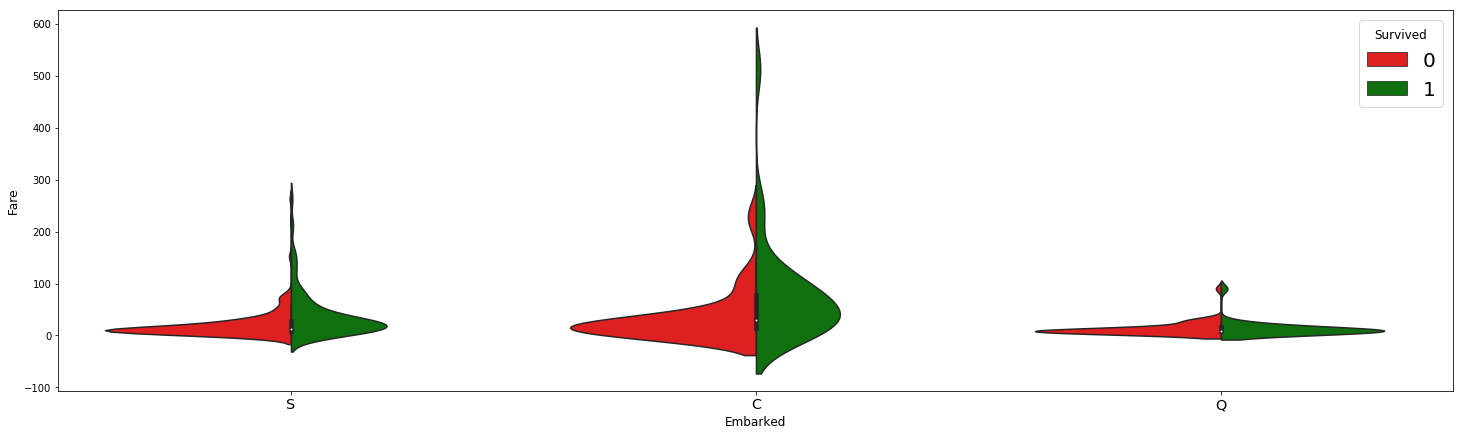

In [9]:
fig=plt.figure(figsize=(25,7))
sns.violinplot(x='Embarked', y='Fare', hue='Survived', data=data, split=True, palette={0: 'r', 1:'g'})

Here, we see that _C Station_ had a wider range of Fare prices. People who paid more here were more likely to live. We see this happening to a lesser extent in _S Station_. At _Q Station_, cheaper fares were sold. 

## Feature Engineering

Start with appending the training set and testing set together. We will create new features from the training set (the first 890 observations), and then add these to the test set.

In [17]:
# Functions

'''
Combines the training and testing data, and returns the combined DataFrame.
'''
def combine_data():
    train = pd.read_csv('./train.csv')
    test = pd.read_csv('./test.csv')
    
    # Extract and then remove targets from training
    train_targets = train.Survived
    train.drop(['Survived'], 1, inplace=True)
    
    combined_data = train.append(test)
    combined_data.reset_index(inplace=True)
    
    # Drop PassengerID and index from combined_data
    combined_data.drop(['index', 'PassengerId'], inplace=True, axis=1)
    
    return combined_data

'''
Extracts the title from each name and maps it to the provided dictionary.
'''
def get_titles(data, title_dict):
    data['Title'] = data['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
    
    data['Title'] = data.Title.map(title_dict)
    return data

'''
Helper function for process_age().
Returns the median age that matches the passengers Sex, Title, and Pclass.
'''
def fill_age(row, grouped_median):
    condition = (
        (grouped_median['Sex'] == row['Sex']) &
        (grouped_median['Title'] == row['Title']) &
        (grouped_median['Pclass'] == row['Pclass'])
    )
    return grouped_median[condition]['Age'].values[0]

'''
Fills in the missing age data with the respective median in the provided row.
'''
def process_age(data, median_data):
    data['Age'] = data.apply(lambda row: fill_age(row, median_data) if np.isnan(row['Age']) else row['Age'], axis=1)
    return data

'''
Drops the Name column from the data and dummy encodes the Title column.
'''
def process_names(data):
    data.drop('Name', axis=1, inplace=True)
    
    dummy_titles = pd.get_dummies(data['Title'], prefix='Title')
    data = pd.concat([data, dummy_titles], axis=1)
    
    data.drop('Title', axis=1, inplace=True)
    
    return data

In [18]:
combined_data = combine_data()
print(combined_data.shape)
combined_data.head()

(1309, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature Extraction

#### Extract Title from Name
Extract the title of each passenger from the Name column in the training data and create a new categorical feature from it. 

In [19]:
# titles = set()
# for name in data['Name']:
#     titles.add(name.split(',')[1].split('.')[0].strip()) # Extract titles 
title_dict = {
    'Ms': 'Miss',
    'Mlle': 'Miss',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Mme': 'Mrs',
    'Mr': 'Mr',
    'Rev': 'Officer',
    'Capt': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Dr': 'Officer',
    'Sir': 'Royalty',
    'Don': 'Royalty',
    'Lady': 'Royalty',
    'Jonkheer': 'Royalty',
    'the Countess': 'Royalty',
    'Master': 'Master'
}

combined_data = get_titles(combined_data, title_dict)
combined_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


#### Process Age
Since there are 177 missing values for age, it would make sense to fill in these missing values with the median Age. However, these ages would differ depending on the groups and categories of the passengers.

To explore this further, let's group our dataset by Sex, Title, and Pclass and see what the median age is in each category.

In [20]:
grouped_train = combined_data.iloc[:891].groupby(['Sex', 'Title', 'Pclass'])
grouped_train_median = grouped_train.median()
grouped_train_median = grouped_train_median.reset_index()[['Sex', 'Title', 'Pclass', 'Age']]

grouped_train_median.head()

,Sex,Title,Pclass,Age
0,female,Miss,1,30.0
1,female,Miss,2,24.0
2,female,Miss,3,18.0
3,female,Mrs,1,40.0
4,female,Mrs,2,32.0


The first line groups each observation by Sex, Title, and Pclass. 
Then, for each combination of these 3 categories, we find the median of the other categories in combined_data.
Finally, since we just care about the Age, we subset our result from the second line and then print it out. 

_How it should be read:_

If the passenger is female, from class 1, with the title Miss, then the median age is 30.

Now, we use a method that fills in the missing ages in combined_data.

In [21]:
combined_data = process_age(combined_data, grouped_train_median)

#### Process Names
Drop the names column since we got the title, and encode the Title variable using dummy variable encoding provided by pandas. This turns the Title column into a quantitative variable.

In [22]:
combined_data = process_names(combined_data)
combined_data.head()